In [1]:
import os, sys
root_path = os.path.abspath(os.path.join('..'))
if root_path not in sys.path:
    sys.path.append(root_path)

In [2]:
from e_nose import file_reader 
from e_nose import data_processing as dp
from e_nose import data_visualization
from e_nose.measurements import Measurement

%reload_ext autoreload
%autoreload 2

# Process data

read in data from a specific file

or all files from a from a directory

In [88]:
data_tuple = file_reader.read_all_files_in_folder('../data/newgen-test')
#data_tuple = dp.remove_broken_channels_multi_files(data_tuple)
functionalisations, working_channels, all_data = data_tuple

Reading file ../data/newgen-test/data_coffee_powder_orange_juice_isopropanol_raisin_red_Wine_wodka_10_loops_for_5.0_min_referenceTime_30.0_min_2020-2-28_7_57.csv
using sensor 5 specification
Read 1 files


## Data normalization tests for a single functionalization

In [109]:
num_from = 7000
num_to = 20000
#brokens = [22,27,31,35,39]
channels = (functionalisations > 5).nonzero()[0]#range(0, num_channels, 1)#[50,14]#range(0,2)#np.array(range(0, num_channels, 3))
#channels = range(0, num_channels, 1)#[50,14]#range(0,2)#np.array(range(0, num_channels, 3))
#channels = [4,30]#range(0,2)#np.array(range(0, num_channels, 3))
#channels = range(10,11)#np.array(range(0, num_channels, 3))

colors = ['xkcd:black', 'xkcd:blue', 'xkcd:brown', 'xkcd:golden yellow', 'xkcd:emerald green',
              'xkcd:baby blue', 'xkcd:magenta', 'xkcd:violet', 'xkcd:lightgreen', 'xkcd:dark rose',
          'xkcd:brownish green']

In [91]:
import numpy as np
data = next(iter(all_data.values()))

In [92]:
num_channels = len(functionalisations)
orig_data_matrix = np.zeros((len(data), num_channels))

for i, time in enumerate(data):
    channel_data = data[time]['channels']
    orig_data_matrix[i, :] = channel_data

orig_data_matrix = orig_data_matrix[0:59_000]
data_matrix = orig_data_matrix

In [93]:
# Tag broken channels
#brokens = np.array([5,6,32,42])#[22,31])
brokens = np.invert(working_channels)
functionalisations[brokens] = -1

In [107]:
def plotChannels(data_matrix):
    fig, ax = plt.subplots()
    for i in channels:
        ax.plot(range(num_from, num_from+len(data_matrix[num_from:num_to, i])), data_matrix[num_from:num_to, i],
                label='%i: %i' % (functionalisations[i], i))
    ax.legend(loc='upper left', bbox_to_anchor= (1.0, 1.0))
    plt.show()
#plotChannels(orig_data_matrix)

Raw


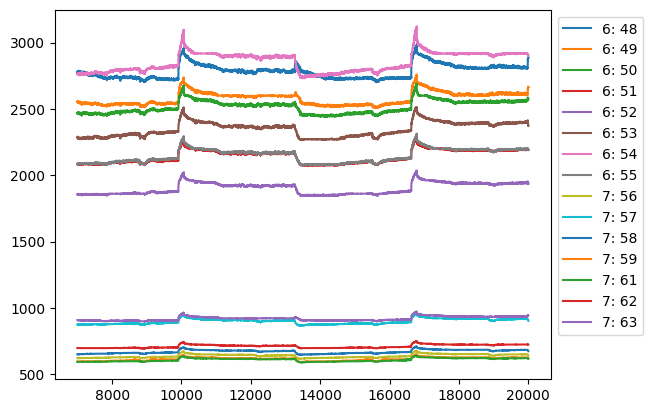

Log


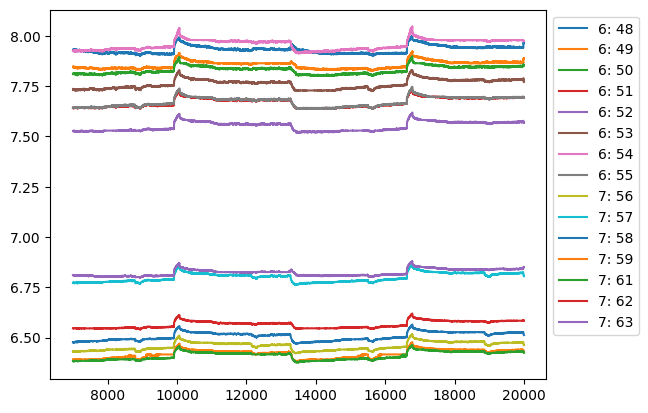

Center


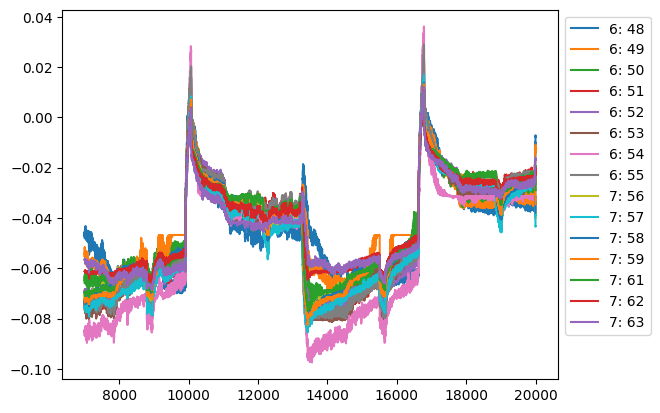

Low-pass


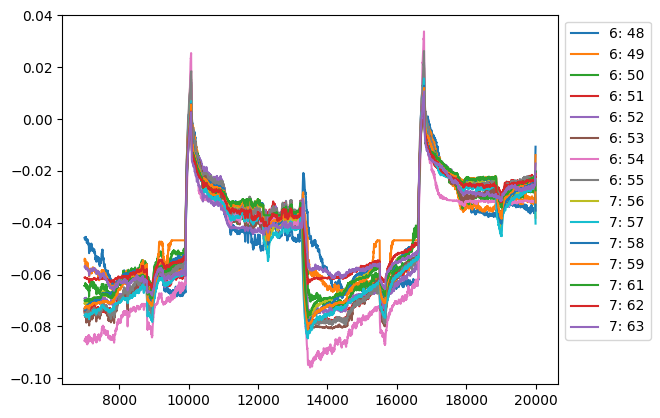

High-pass


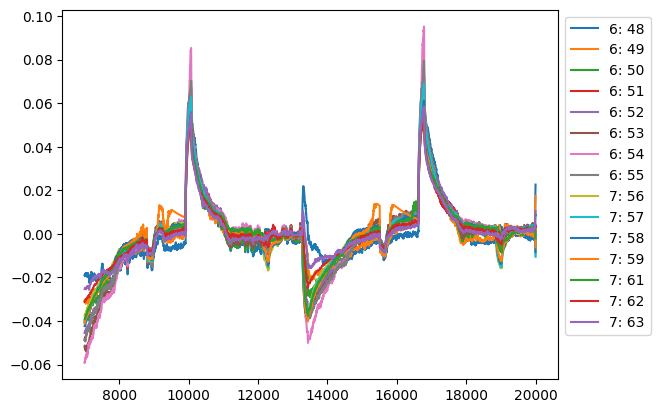

Normed


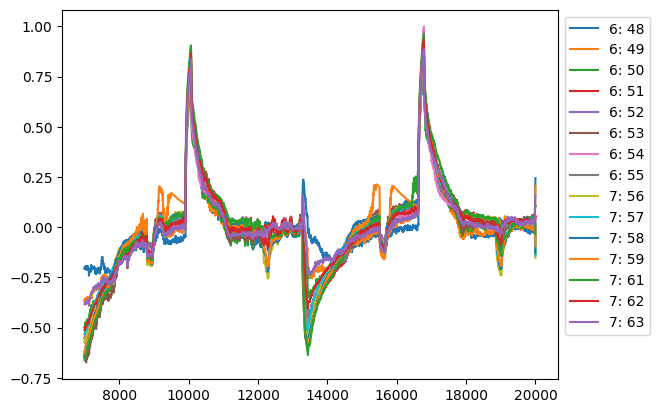

Average removed


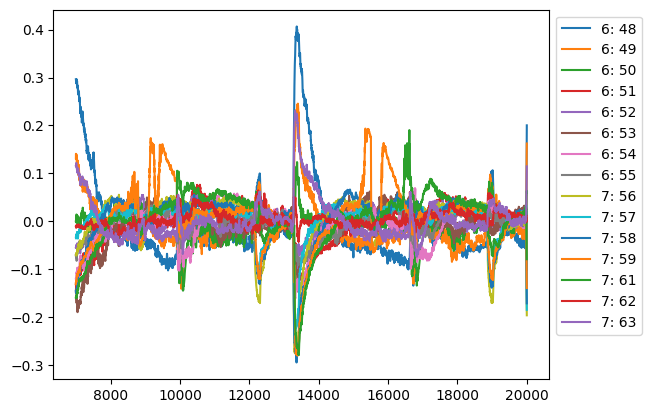

In [110]:
print("Raw")
plotChannels(orig_data_matrix)

# log scale
data_matrix = np.log(orig_data_matrix)

print("Log")
plotChannels(data_matrix)

data_matrix -= np.mean(data_matrix, axis=0, keepdims=True)

print("Center")
plotChannels(data_matrix)

# high-pass filter
l1_filter = data_matrix[0]
l1_factor = 2e-1
for i in range(len(data_matrix)):
    l1_filter = (l1_filter + data_matrix[i] * l1_factor) / (1.0+l1_factor)
    data_matrix[i] = l1_filter

print("Low-pass")
plotChannels(data_matrix)

# high-pass filter
l1_filter = data_matrix[0]
l1_factor = 1e-3
for i in range(len(data_matrix)):
    l1_filter = (l1_filter + data_matrix[i] * l1_factor) / (1.0+l1_factor)
    data_matrix[i] -= l1_filter

print("High-pass")
plotChannels(data_matrix)

# norm by variance
data_var = np.max(data_matrix, axis=0, keepdims=True)
data_matrix /= data_var+1e-6

print("Normed")
plotChannels(data_matrix)

# remove baseline functionalisation 0
mask = np.ones(data_matrix.shape[1], bool)
mask[brokens] = False
func_0 = np.mean(data_matrix[:,mask], axis=1, keepdims=True)
data_matrix = data_matrix - func_0

print("Average removed")
plotChannels(data_matrix)

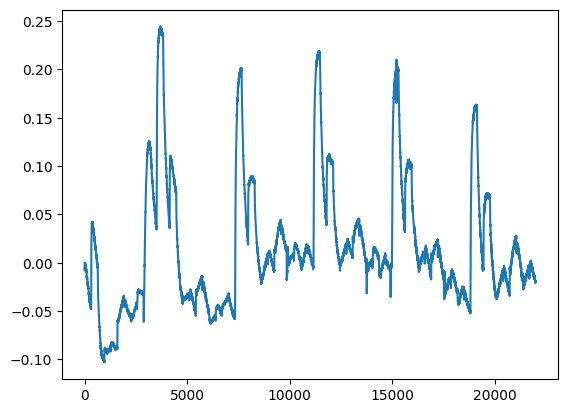

In [11]:
fig, ax = plt.subplots()
ax.plot(func_0)
plt.show()

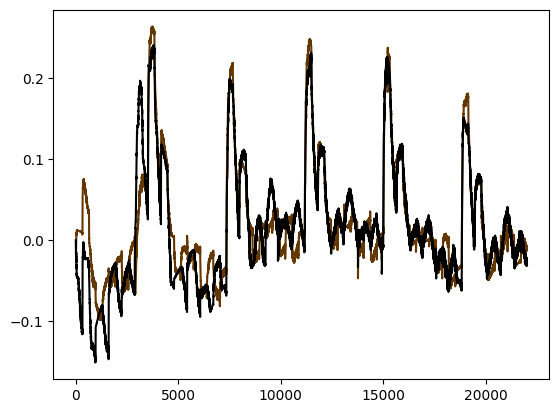

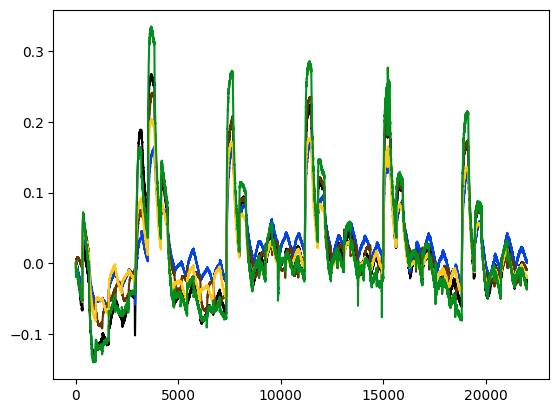

In [12]:
fig, ax = plt.subplots()
for i in channels:
    ax.plot(range(num_from, num_from+len(data_matrix[num_from:num_to, i])), data_matrix[num_from:num_to, i],
            color=colors[functionalisations[i]])
#for f in range(max(functionalisations)+1):
#    ax.plot(range(num_from, num_from+len(data_matrix[num_from:num_to, 0])),
#            np.mean(data_matrix[num_from:num_to, functionalisations == f], axis=1),
#            color=colors[f])
plt.show()


fig, ax = plt.subplots()
for f in range(max(functionalisations)+1):
    ax.plot(range(num_from, num_from+len(data_matrix[num_from:num_to, 0])),
            np.mean(data_matrix[num_from:num_to, functionalisations == f], axis=1),
            color=colors[f])
plt.show()

## Correlation between Channels

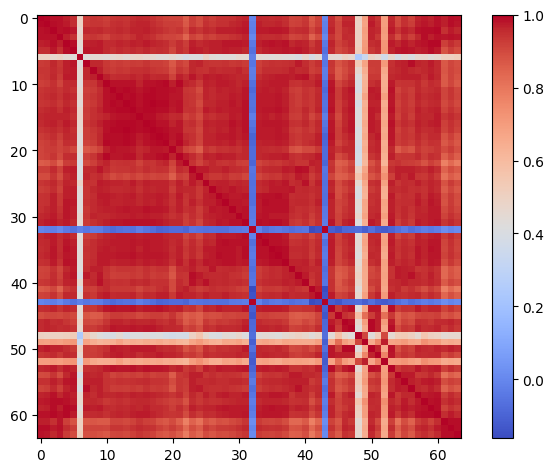

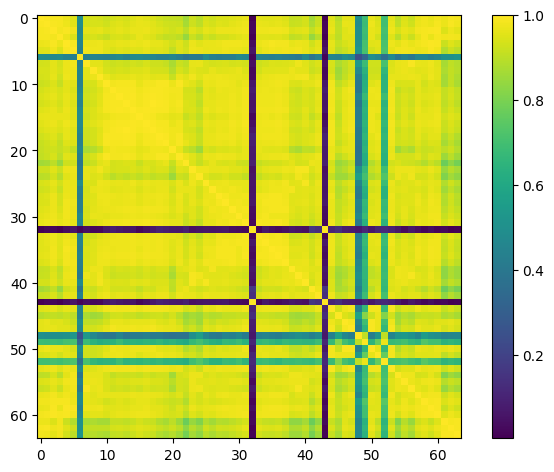

In [13]:
corr = np.corrcoef(data_matrix[:], rowvar=False)

fig, ax = plt.subplots()
im = ax.imshow(corr, cmap="coolwarm")
fig.tight_layout()
fig.colorbar(im, ax=ax)
plt.show()

fig, ax = plt.subplots()
im = ax.imshow(abs(corr))
fig.tight_layout()
fig.colorbar(im, ax=ax)
plt.show()



[ 2  3  5  7 24 25 26 27 56 57 58 59 60 61  3]
(59000, 15)


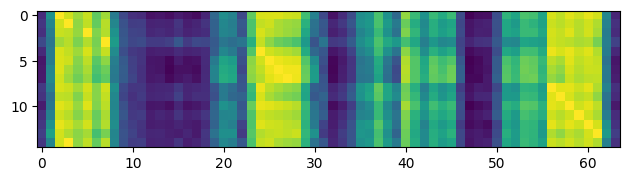

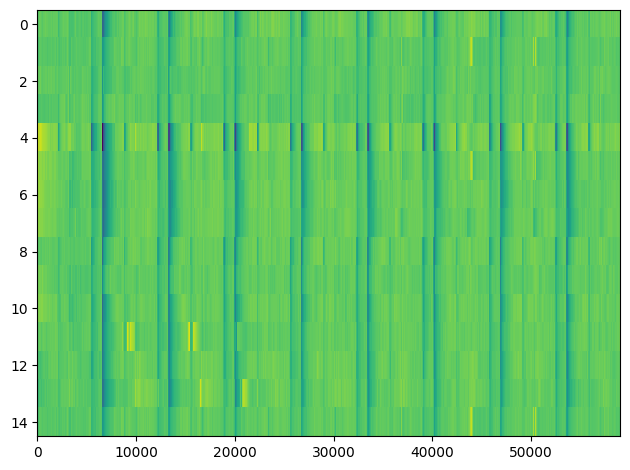

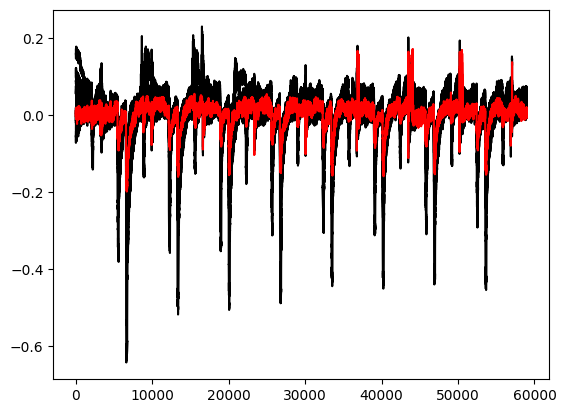

In [294]:
# Channels that are very similar / dissimilar to:
c = 3
cgroup = np.append(np.where(corr[c] > 0.7), c)
#cgroup = np.append(np.where(np.abs(corr)[c] < 0.2), c)
print(cgroup)
print(np.squeeze(data_matrix[:,cgroup]).shape)

fig, ax = plt.subplots()
im = ax.imshow(np.squeeze(corr[cgroup]))
fig.tight_layout()
plt.show()

fig, ax = plt.subplots()
im = ax.imshow(np.squeeze(data_matrix[:,cgroup]).T, aspect='auto')
fig.tight_layout()
plt.show()

num_from = 0#000
num_to = -1#15000
fig, ax = plt.subplots()
for cg in cgroup:
    ax.plot(range(num_from, num_from+len(data_matrix[num_from:num_to, 0])),
        data_matrix[num_from:num_to, cg], color=('r' if cg==c else 'k'))
plt.show()

In [295]:
# Cluster channels that behave similarly

from scipy.cluster.vq import kmeans2
centroid, label = kmeans2(data_matrix.T, 10, minit='points', iter=100)
#centroid, label = kmeans2(np.abs(corr), 5, minit='points', iter=100)
label

array([2, 8, 5, 5, 5, 5, 8, 5, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 8, 8, 3, 8,
       1, 3, 5, 5, 5, 5, 5, 3, 8, 1, 2, 2, 6, 6, 6, 6, 6, 6, 3, 4, 7, 7,
       4, 7, 7, 0, 0, 0, 7, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 8, 2],
      dtype=int32)

[3 3 3 3 3]
7
(array([ 8, 23, 40, 41, 42, 43, 44, 45, 51, 52, 53, 54, 55]),)


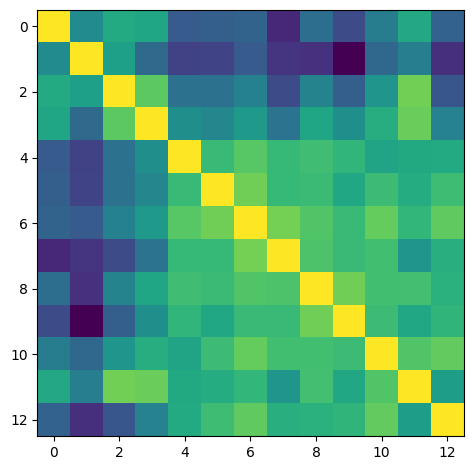

In [135]:
brokens = [22,27,31,35,39]
print(label[brokens])
print(label[47])
print(np.where(label == 9))
pcorr = np.corrcoef(data_matrix[:, label==9], rowvar=False)

fig, ax = plt.subplots()
im = ax.imshow(pcorr)
fig.tight_layout()
plt.show()

In [ ]:
new_funcs = np.array(
    [1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
     3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
     5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0,
     6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7]
)

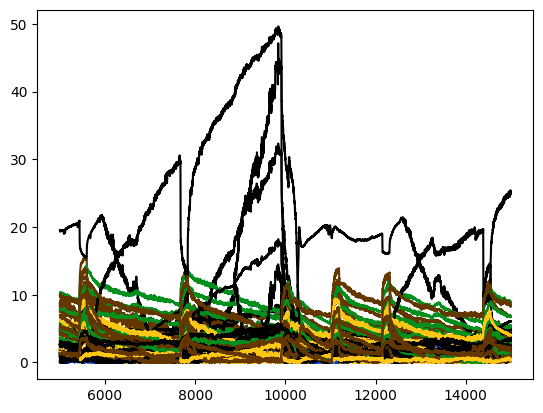

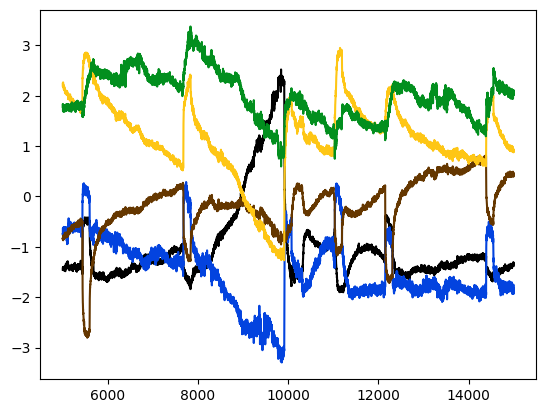

In [239]:
num_from = 5000
num_to = 15000
channels = np.array(range(num_channels))#[label==4]#range(0, num_channels, 1) #range(num_channels)

colors = ['xkcd:black', 'xkcd:blue', 'xkcd:brown', 'xkcd:golden yellow', 'xkcd:emerald green',
              'xkcd:baby blue', 'xkcd:magenta', 'xkcd:violet', 'xkcd:lightgreen', 'xkcd:dark rose',
          'xkcd:brownish green']
fig, ax = plt.subplots()
for i in channels:
    ax.plot(range(num_from, num_from+len(data_matrix[num_from:num_to, i])), np.abs(data_matrix[num_from:num_to, i]),
            color=colors[label[i]])
#for f in range(max(functionalisations)+1):
#    ax.plot(range(num_from, num_from+len(data_matrix[num_from:num_to, 0])),
#            np.mean(data_matrix[num_from:num_to, functionalisations == f], axis=1),
#            color=colors[f])
plt.show()


fig, ax = plt.subplots()
for f in range(max(label)+1):
    ax.plot(range(num_from, num_from+len(data_matrix[num_from:num_to, 0])),
            np.mean(data_matrix[num_from:num_to, label == f], axis=1),
            color=colors[f])
plt.show()